## HW 7
Botasheva Zhanna

## Памперсы или пиво? Практический проект по созданию рекомендательной системы

In [18]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
# подгружаем данные
data = pd.read_json('C:/Users/Zhanna Botasheva/Desktop/Курс ML/Professional/33 Практическое занятие по рекомендательным системам. Surpsise/Gift_Cards_5.json.gz', orient='records', lines=True)
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"06 17, 2018",A31UBHTUUIFJUT,B004LLIKVU,{'Gift Amount:': ' 50'},john stoiber,Another great gift.,Five Stars,1529193600,NaN,NaN
1,4,True,"06 14, 2018",A2MN5JQMIY0FQ2,B004LLIKVU,{'Gift Amount:': ' 50'},Amazon Customer,Gift card for my daughter,Ease of use,1528934400,NaN,NaN
2,5,True,"06 2, 2018",A25POI5IGGENPM,B004LLIKVU,{'Gift Amount:': ' 50'},Kindle Customer,Nice present,Five Stars,1527897600,NaN,NaN
3,5,True,"05 19, 2018",A2HYGTHB4LJ9FW,B004LLIKVU,{'Gift Amount:': ' 50'},Amante dei Gatti,My niece loved this birthday greeting/gift card.,Love the convenience of eCards,1526688000,NaN,NaN
4,5,True,"05 18, 2018",ACDG3M94UMZGJ,B004LLIKVU,{'Gift Amount:': ' 50'},Joan Freesh,fine as a gift.,Five Stars,1526601600,NaN,NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2972 entries, 0 to 2971
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         2972 non-null   int64  
 1   verified        2972 non-null   bool   
 2   reviewTime      2972 non-null   object 
 3   reviewerID      2972 non-null   object 
 4   asin            2972 non-null   object 
 5   style           864 non-null    object 
 6   reviewerName    2972 non-null   object 
 7   reviewText      2966 non-null   object 
 8   summary         2972 non-null   object 
 9   unixReviewTime  2972 non-null   int64  
 10  vote            208 non-null    float64
 11  image           12 non-null     object 
dtypes: bool(1), float64(1), int64(2), object(8)
memory usage: 258.4+ KB


In [11]:
data.describe()

,overall,unixReviewTime,vote
count,2972.000000,2.972000e+03,208.000000
mean,4.885262,1.476136e+09,5.158654
std,0.484660,3.379616e+07,7.366121
min,1.000000,1.327968e+09,2.000000
25%,5.000000,1.454890e+09,2.000000
50%,5.000000,1.482710e+09,3.000000
75%,5.000000,1.500271e+09,5.000000
max,5.000000,1.534896e+09,60.000000


In [13]:
data.overall.value_counts()

overall
5    2752
4     154
3      33
1      22
2      11
Name: count, dtype: int64

In [15]:
num_columns = data.select_dtypes(include=['int64','float64']).columns.tolist()
num_columns

['overall', 'unixReviewTime', 'vote']

In [16]:
for column in num_columns:
    print(f'{column} {data[column].nunique()}')

overall 5
unixReviewTime 797
vote 20


<Axes: xlabel='overall', ylabel='count'>

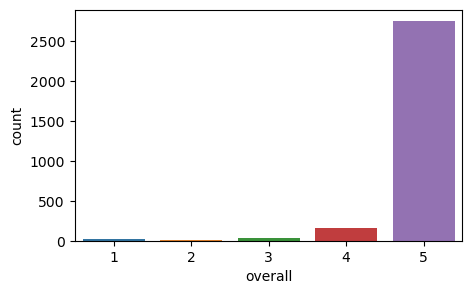

In [19]:
plt.figure(figsize=(5, 3))
sns.countplot(x='overall', data=data)

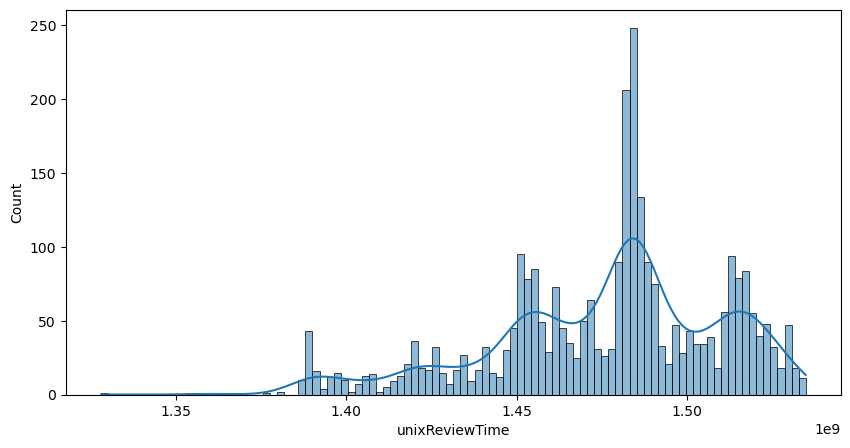

In [20]:
plt.figure(figsize=(10, 5))
sns.histplot(x='unixReviewTime', bins=100, kde=True, data=data)
plt.show()

In [21]:
cat_columns = data.select_dtypes(include='object').columns.tolist()
cat_columns

['reviewTime',
 'reviewerID',
 'asin',
 'style',
 'reviewerName',
 'reviewText',
 'summary',
 'image']

In [22]:
for column in cat_columns:
    print(f'{column} {data[column].value_counts().sum()}')

reviewTime 2972
reviewerID 2972
asin 2972
style 864
reviewerName 2972
reviewText 2966
summary 2972
image 12


In [23]:
def train_test_split(X, ratio=0.2, user_col='reviewerID', item_col='asin',
                     rating_col='overall', time_col='unixReviewTime'):
  
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)

    # список всех пользователей
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []

    for userId in tqdm_notebook(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])

    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)

    return X_train, X_test, y_train, y_test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data)

  0%|          | 0/458 [00:00<?, ?it/s]

In [25]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((2223, 2), 2223, (749, 2), 749)

In [26]:
X_train.head(3)

,reviewerID,asin
0,A2K90J2GLB0B8D,B005ESMMWW
1,A2K90J2GLB0B8D,B0080IR6BA
2,A2K90J2GLB0B8D,B0091JKJ0M


In [27]:
y_train[1:10]

array([4, 4, 5, 5, 4, 5, 5, 4, 5], dtype=int64)

### Collaborative filtering
### User-based model

In [28]:
class UserBased(BaseEstimator):

    def fit(self, X, y, user_col='reviewerID', item_col='asin'):

        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку пользователя
        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        
        # создаём векторы для каждого пользователя из купленных предметов
        # для неизвестных предметов ставим оценку 0
        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        
        # считаем попарную схожесть между пользователями
        self.user_sim = cosine_similarity(self.user_ratings)
        
        # также сделаем словарь - {значение user_col: index в user_ratings}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self

    
    def predict_rating(self, pr_user, pr_item):

        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # и модель не должна это учитывать
        denominator = np.abs(self.user_sim[self.user_pos[pr_user]]).sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator

    
    def predict(self, X, user_col='reviewerID', item_col='asin'):

        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [29]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

In [30]:
%%time
print('start fitting...')
ub = UserBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ub.predict(X_test))))

start fitting...
start predicting...
rmse = 0.48612924036787514
CPU times: total: 281 ms
Wall time: 154 ms


### Item-based model

In [32]:
class ItemBased(BaseEstimator):

    def fit(self, X, y, user_col='reviewerID', item_col='asin'):

        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого предмета с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между предметами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]

        return self
    

    def predict_rating(self, pr_user, pr_item):

        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    

    def predict(self, X, user_col='reviewerID', item_col='asin'):

        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y

In [33]:
%%time
print('start fitting...')
ib = ItemBased().fit(X_train, y_train)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, ib.predict(X_test))))

start fitting...
start predicting...
rmse = 0.4791070868638017
CPU times: total: 156 ms
Wall time: 181 ms


RMSE для для данных моделей получился практически одинаковый.